## Spherical Splines based on Jupp & Kent (1987)

This notebook implements the algorithm for fitting splines introdiced in [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843). The same implements a series of projections of spherical data to the 2D plane and then applies splines fit there. 

In [1]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 20)

from utils.spherical_splines import *

In [2]:
%load_ext autoreload
%autoreload 2

As an example, we are going to use the same example the authors use in the paper. Something that is not clear is what to do with points with same age. Traditional splines methods don't allow to use more than one data point per same age/dependent variable. 

In [5]:
# example = 'real_poles'
# example = 'toy'
example = 'Torsvik2012'

if example == 'real_poles':

    df = pd.read_csv('data/df_pole_compilation_by_study.csv', encoding="cp1254")
    df['Time'] = df['mean_age']
    df['Lat'] = - df['Plat'] # reverse latitude to coincide with north pole following the defaul to Jupp
    df['Lon'] = df['Plon']
    df = df[['Time', "Lat", 'Lon']]


elif example == 'toy':  
    
    df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")

    # In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
    # we replace poles with same age by picking the first one in the age
    df = df.groupby(['Time']).first().reset_index()
    #df['Time'] += np.random.normal(0, 0.001, df.shape[0])
    df['Lat'] = 90 - df['Time'] * 0.1
    df['Lon'] = df['Time'] * 0.5 

if example == 'Torsvik2012':
    df = pd.read_csv('data/Torsvik-etal-2012_dataset.csv', encoding="cp1254")
    df = df[df.Plate.isin(['Amazonia', 'Parana', 'Colorado', 'Southern_Africa'])]
    print(np.unique(df.Plate))
    df.RLat.fillna(df.Lat, inplace=True)
    df.RLon.fillna(df.Lon, inplace=True)
    df['Time'] = df['Age']
    df['Lat'] = - df['RLat'] # reverse latitude to coincide with north pole following the defaul to Jupp
    df['Lon'] = df['RLon']
    df = df.groupby(['Time']).first().reset_index()
    df = df[['Time', "Lat", 'Lon', 'Q']]
    
# Add cartesian coordinates
df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')

df

['Amazonia' 'Colorado' 'Parana' 'Southern_Africa']


,Time,Lat,Lon,Q,x,y,z
0,8.5,85.5,-37.4,3,0.062329,-0.047654,0.996917
1,9.5,84.4,-26.3,5,0.087482,-0.043236,0.995227
2,65.5,66.8,52.3,3,0.240906,0.311696,0.919135
3,70.5,69.6,46.8,5,0.238614,0.254098,0.937282
4,84.0,71.8,48.8,6,0.205732,0.235005,0.949972
5,85.0,67.5,44.3,5,0.273884,0.267272,0.923880
6,90.5,64.1,46.1,5,0.302879,0.314738,0.899558
7,92.0,69.5,65.2,3,0.146895,0.317910,0.936672
8,95.5,73.0,71.4,4,0.093255,0.277101,0.956305
9,102.0,63.5,69.8,4,0.154071,0.418754,0.894934


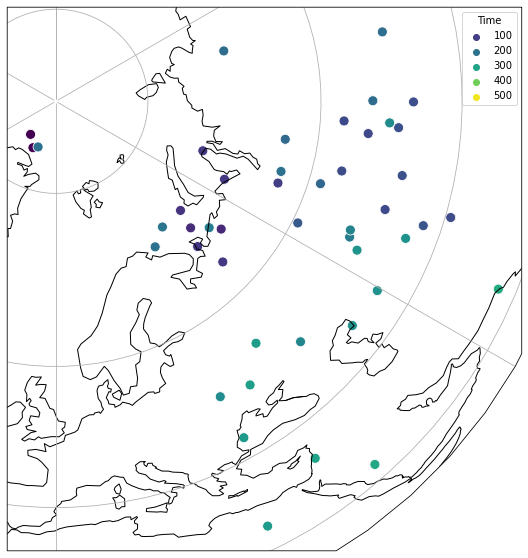

In [6]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Experiment

In [30]:
%%time

log_smoothings = np.linspace(-4, -1, 20)
smoothings = 10 ** log_smoothings
# smoothings = [0.0001]

all_curves = {}

for s in smoothings:
    
    print("Running smoothing = ", s)
    
    final_curve = spherical_spline(times=df.Time.values,
                                   knot_values=df[['x','y','z']].values,
                                   smoothing=s,
                                   precision=0.1,
                                   ode_stepsize=0.01,    # never pick less than 0.01
                                   n_iter=10,
                                   weights=df.Q.values,
                                   fix_origin=True)
    all_curves[s] = final_curve

Running smoothing =  0.0001
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0001438449888287663
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.00020691380811147902
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.00029763514416313193
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.00042813323987193956
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0006158482110660267
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0008858667904100823
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0012742749857031334
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0018329807108324356
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.0026366508987303583
Maximul tolerance reached after a total of 10 iterations.
Ru

Smooth:  0.007847599703514606


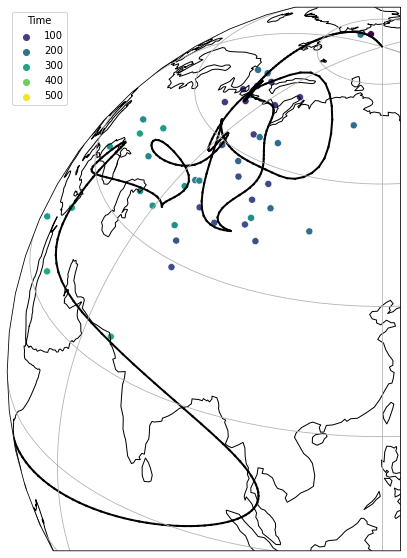

In [38]:
all_keys = list(all_curves.keys())
idx = 12
s = all_keys[idx]
print('Smooth: ', s)

curve = all_curves[s]

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=30, central_longitude=120))

ax.coastlines()
ax.gridlines()

# the first point is just noise... 
sph_splines = curve.knot_values[1:]

knot_values_sph = cart2sph(sph_splines, radians=False)[::10,:]

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color='black',
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=50,
                palette="viridis",
                transform = ccrs.PlateCarree());